<a href="https://colab.research.google.com/github/Joocheol/Financial-Engineering/blob/master/Two_versions_of_delta_hedging_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
S0 = 100
K = 100
T = 30/365
r = 0.00
sig = 0.2


M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [3]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

In [4]:
S.shape

(1000, 31)

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

In [5]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

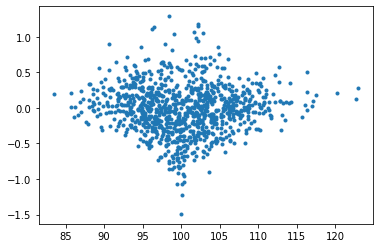

In [6]:
a = []

K = 100

for i in range(M):
    cost = 0
    hedge = 0
    for j in range(N):
        d1 = (np.log(S[i,j]/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1) - 1
        cost = cost + (delta-hedge) * S[i,j]
        hedge = delta
    
    cost = cost - hedge * S[i,N] + np.maximum(K-S[i,N], 0) - bsput(S0,K,T,r,sig)
    #cost = cost - hedge * S[i,N]
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

(array([  2.,   5.,  29., 102., 233., 362., 190.,  61.,   8.,   8.]),
 array([-1.49160693, -1.21339729, -0.93518765, -0.656978  , -0.37876836,
        -0.10055872,  0.17765092,  0.45586057,  0.73407021,  1.01227985,
         1.29048949]),
 <a list of 10 Patch objects>)

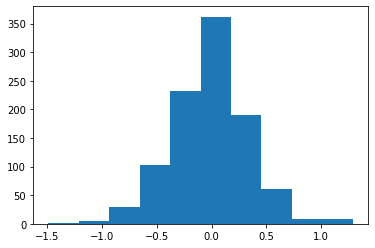

In [7]:
plt.hist(a)

$(\Delta_0 - 0) S_0 + (\Delta_1 - \Delta_0) S_1 + (\Delta_2 - \Delta_1) S_{2} + \cdots + (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}+ (\Delta_{T} - \Delta_{T-1}) S_T$

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

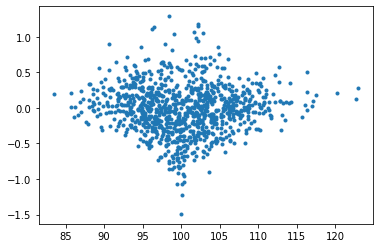

In [8]:
a = []

for i in range(M):
    cost = 0
    price = S[i,0]
    for j in range(N):
        d1 = (np.log(price/K)+(r+0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
        delta = norm.cdf(d1)
        cost = cost + delta*(price-S[i,j+1])
        price = S[i,j+1]
    
    cost = cost + np.maximum(S[i,N]-K, 0) - bscall(S0,K,T,r,sig)
        

    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

In [9]:
import tensorflow as tf

In [17]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [premium] + [hedge_cost] + [price]

# premium = tf.keras.layers.Dense(1, activation='linear', trainable=True,
#                 kernel_initializer=tf.keras.initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
#                 bias_initializer=tf.keras.initializers.RandomNormal(0,1))(premium)

for j in range(N):
    
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='tanh')(delta)
    delta = tf.keras.layers.Dropout(0.5)(delta)
    #delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='tanh')(delta)
    delta = tf.keras.layers.Dense(1)(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
    my_input = my_input + [new_price]


    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="multiply_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

cum_cost = hedge_cost

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

#tf.keras.utils.plot_model(model)

In [18]:
p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p]+[c]+[SS]
y = - np.maximum(S[:,N]-K, 0).reshape(M,1) + p

In [19]:
y.shape

(1000, 1)

In [20]:
model.compile(loss='mse', optimizer='adam')

In [21]:
hist = model.fit(x,y, batch_size=32, epochs=100,  verbose=True)

Epoch 1/100
32/32 [==============================] - 17s 57ms/step - loss: 6.5485
Epoch 2/100
32/32 [==============================] - 2s 58ms/step - loss: 1.8987
Epoch 3/100
32/32 [==============================] - 2s 53ms/step - loss: 1.4696
Epoch 4/100
32/32 [==============================] - 2s 52ms/step - loss: 1.3520
Epoch 5/100
32/32 [==============================] - 2s 54ms/step - loss: 1.2100
Epoch 6/100
32/32 [==============================] - 2s 56ms/step - loss: 1.1617
Epoch 7/100
32/32 [==============================] - 2s 57ms/step - loss: 1.1230
Epoch 8/100
32/32 [==============================] - 2s 57ms/step - loss: 1.1141
Epoch 9/100
32/32 [==============================] - 2s 54ms/step - loss: 1.0407
Epoch 10/100
32/32 [==============================] - 2s 56ms/step - loss: 0.9519
Epoch 11/100
32/32 [==============================] - 2s 54ms/step - loss: 0.9266
Epoch 12/100
32/32 [==============================] - 2s 53ms/step - loss: 0.9957
Epoch 13/100
32/32 [====

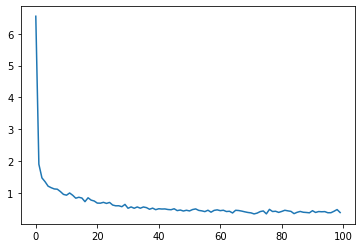

In [22]:
plt.plot(hist.history['loss'])

(array([  3.,   5.,   4.,  15.,  18.,  30.,  41.,  69.,  97., 123., 138.,
        119., 114.,  87.,  69.,  39.,  19.,   8.,   1.,   1.]),
 array([-14.990554 , -13.5758   , -12.161046 , -10.746291 ,  -9.331537 ,
         -7.9167833,  -6.5020294,  -5.087275 ,  -3.672521 ,  -2.257767 ,
         -0.8430128,   0.5717413,   1.9864954,   3.4012494,   4.816004 ,
          6.2307577,   7.6455116,   9.060266 ,  10.47502  ,  11.889774 ,
         13.304528 ], dtype=float32),
 <a list of 20 Patch objects>)

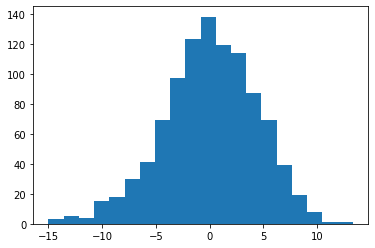

In [23]:
plt.hist(model.predict(x), bins=20)